# Crypto Clustering (Panel Time-Series → Coin Profiles)

**Mục tiêu:** Phân cụm mã crypto dựa trên **hành vi thống kê** (volatility, skewness, liquidity, autocorrelation, …)
từ dữ liệu dạng **panel time-series không đều**.

**Pipeline:**
1. Nạp dữ liệu đã tiền xử lý (`processed_cryptotocurrency.csv`), chuẩn hóa `timestamp`.
2. Thống kê chất lượng chuỗi cho mỗi `symbol` (số điểm, độ phủ, khoảng cách thời gian).
3. Lọc các mã có chuỗi đủ dài/dày để đặc trưng ổn định.
4. Tạo vector đặc trưng cho từng `symbol` (price/return/volume/marketcap + skew/kurtosis + autocorr).
5. Chuẩn hóa, giảm chiều bằng PCA; chọn số cụm bằng silhouette score.
6. Phân cụm (KMeans), trực quan hóa và mô tả cụm.
7. Xuất file: `coin_features.csv`, `coin_clusters.csv`.

## 1) Import thư viện & thiết lập chung

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
print("Libraries imported.")

Libraries imported.


## 2) Nạp dữ liệu & chuẩn hóa thời gian

In [ ]:
DATA_PATH = 'processed_cryptotocurrency.csv'
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['timestamp']).sort_values(['symbol','timestamp']).reset_index(drop=True)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Dải thời gian:", df['timestamp'].min(), "→", df['timestamp'].max())
print("Số symbol duy nhất:", df['symbol'].nunique())
print(df.head(10))

Shape: (60800, 10)
Columns: ['timestamp', 'name', 'symbol', 'price_usd', 'vol_24h', 'total_vol', 'chg_24h', 'chg_7d', 'market_cap', 'name_encoded']
Dải thời gian: 2025-04-01 00:34:00 → 2025-10-12 23:52:00
Số symbol duy nhất: 268
            timestamp   name symbol  price_usd      vol_24h  total_vol  \
0 2025-10-04 10:36:00     0G     0g       3.07  328906282.0     0.0010   
1 2025-10-04 10:39:00     0G     0g       3.07  326561005.0     0.0009   
2 2025-10-04 10:52:00     0G     0g       3.05  219867828.0     0.0006   
3 2025-10-04 11:26:00     0G     0g       3.05  215138181.0     0.0006   
4 2025-10-04 11:43:00     0G     0g       3.04  313025756.0     0.0009   
5 2025-10-04 11:55:00     0G     0g       3.04  213275758.0     0.0006   
6 2025-10-04 10:36:00  1INCH  1inch       0.27   20665604.0     0.0001   
7 2025-10-04 10:39:00  1INCH  1inch       0.26   21171651.0     0.0001   
8 2025-10-04 10:52:00  1INCH  1inch       0.26   21266382.0     0.0001   
9 2025-10-04 11:26:00  1INCH  1

## 3) Đánh giá chất lượng chuỗi theo từng `symbol`

In [ ]:
def quality_stats(group):
    t = group['timestamp'].values
    n = len(t)
    if n < 3:
        return pd.Series({'n_obs': n, 'span_days': 0, 'median_step_min': np.nan,
                          'iqr_over_median': np.nan, 'coverage': 0.0, 'max_gap_h': np.nan})
    dt = np.diff(t).astype('timedelta64[m]').astype(float)
    med = np.nanmedian(dt) if len(dt)>0 else np.nan
    iqr = (np.nanpercentile(dt, 75) - np.nanpercentile(dt, 25)) if len(dt)>0 else np.nan
    span_min = (t[-1] - t[0]).astype('timedelta64[m]').astype(float)
    expected = (span_min / med) if (med and med>0) else np.nan
    coverage = (n / expected) if (expected and expected>0) else np.nan
    max_gap_h = (np.nanmax(dt)/60.0) if len(dt)>0 else np.nan
    span_days = span_min / (60*24) if span_min else 0
    return pd.Series({
        'n_obs': n,
        'span_days': span_days,
        'median_step_min': med,
        'iqr_over_median': (iqr/med) if (med and med>0) else np.nan,
        'coverage': coverage,
        'max_gap_h': max_gap_h
    })

qs = df.groupby('symbol').apply(quality_stats).reset_index()
qs = qs.sort_values('n_obs', ascending=False).reset_index(drop=True)

print("Quality stats (top 10 by n_obs):")
print(qs.head(10))
print("\nTóm tắt:")
print(qs.describe(include='all'))

Quality stats (top 10 by n_obs):
  symbol   n_obs   span_days  median_step_min  iqr_over_median  coverage  \
0   USDC  1725.0  164.958333             60.0              0.0  0.435716   
1    TRX  1725.0  164.958333             60.0              0.0  0.435716   
2    XLM  1725.0  164.958333             60.0              0.0  0.435716   
3   DOGE  1725.0  164.958333             60.0              0.0  0.435716   
4    SOL  1725.0  164.958333             60.0              0.0  0.435716   
5   USDT  1725.0  164.958333             60.0              0.0  0.435716   
6    BNB  1724.0  164.958333             60.0              0.0  0.435464   
7    XRP  1724.0  164.958333             60.0              0.0  0.435464   
8    ETH  1724.0  164.958333             60.0              0.0  0.435464   
9    SUI  1724.0  164.958333             60.0              0.0  0.435464   

   max_gap_h  
0      457.0  
1      457.0  
2      457.0  
3      457.0  
4      457.0  
5      457.0  
6      457.0  
7      457

## 4) Lọc các mã đủ chuẩn

In [ ]:
MIN_SPAN_DAYS     = 2       # Chỉ cần coin xuất hiện >= 2 ngày
MIN_COVERAGE      = 0.15    # Độ phủ dữ liệu tối thiểu 15% (thay vì 40%)
MAX_IQR_OVER_MED  = 5.0     # Dao động trong step giữa các lần ghi nhận được nới lỏng lên



mask = (
    (qs['span_days'] >= MIN_SPAN_DAYS) &
    (qs['median_step_min'].between(MIN_MED_STEP, MAX_MED_STEP, inclusive='both')) &
    (qs['coverage'] >= MIN_COVERAGE) &

    (qs['iqr_over_median'] <= MAX_IQR_OVER_MED)
)

ok_syms = qs.loc[mask, 'symbol'].tolist()
print(f"Số đồng crypto đạt chuẩn: {len(ok_syms)} / {qs['symbol'].nunique()}")
print("Danh sách các đồng crypto đạt chuẩn:", ok_syms[:])

df_ok = df[df['symbol'].isin(ok_syms)].copy()
print("Shape sau lọc dữ liệu:", df_ok.shape)

Số đồng crypto đạt chuẩn: 80 / 268
Danh sách các đồng crypto đạt chuẩn: ['USDC', 'TRX', 'XLM', 'DOGE', 'SOL', 'USDT', 'BNB', 'XRP', 'ETH', 'SUI', 'BTC', 'LINK', 'AVAX', 'ADA', 'HBAR', 'LEOu', 'BCH', 'HYPE', 'TON', 'SHIB', 'LTC', 'eUSDe', 'weth', 'usdc', 'wbtc', 'weeth', 'dai', 'doge', 'usdt', 'xlm', 'okb', 'susde', 'usde', 'usds', 'xrp', 'xmr', 'trx', 'usdt0', 'ada', 'bnb', 'bsc-usd', 'ton', 'sol', 'shib', 'bgb', 'uni', 'wbeth', 'wbt', 'steth', 'sui', 'aave', 'cro', 'figr_heloc', 'hbar', 'bch', 'avax', 'hype', 'mnt', 'link', 'ltc', 'leo', 'eth', 'wlfi', 'btc', 'cbbtc', 'wsteth', 'dot', 'near', 'pepe', 'ena', 'apt', 'm', 'pDOTn', 'CRO', 'zec', 'OM', 'tao', 'jitosol', 'PI', 'DAI']
Shape sau lọc dữ liệu: (59637, 10)


## 5) Biến mỗi coin thành **một vector đặc trưng**

In [ ]:
# --- Tiền xử lý: thêm các cột log để giảm ảnh hưởng outlier ---
df_ok['price_usd_log'] = np.log1p(df_ok['price_usd'])
df_ok['vol_24h_log'] = np.log1p(df_ok['vol_24h'])
df_ok['market_cap_log'] = np.log1p(df_ok['market_cap'])


# --- Cập nhật hàm feature vector ---
def summarize_coin(g):
    g = g.sort_values('timestamp')
    price = np.log1p(g['price_usd'])
    vol = np.log1p(g['vol_24h'])
    mcap = np.log1p(g['market_cap'])
    chg24 = g['chg_24h']
    chg7 = g['chg_7d']
    ret = price.pct_change().dropna()

    def safe_autocorr(x, lag): return x.autocorr(lag=lag) if len(x) > lag+1 else np.nan
    def safe_kurt(x): return x.kurtosis() if len(x.dropna()) > 2 else np.nan

    return pd.Series({
        'price_mean': price.mean(),
        'price_std': price.std(),
        'price_skew': price.skew(),
        'price_kurt': safe_kurt(price),
        'return_mean': ret.mean(),
        'return_abs_mean': ret.abs().mean(),
        'return_std': ret.std(),
        'return_skew': ret.skew(),
        'return_iqr': iqr(ret),
        'vol_mean': vol.mean(),
        'vol_std': vol.std(),
        'chg24_std': chg24.std(),
        'chg7_std': chg7.std(),
        'mcap_mean': mcap.mean(),
        'mcap_std': mcap.std(),
        'volume_to_marketcap': (vol / (mcap + 1e-6)).mean(),
        'autocorr_lag1': safe_autocorr(price, 1),
        'autocorr_lag2': safe_autocorr(price, 2),
        'autocorr_vol_lag1': safe_autocorr(vol, 1)
    })



features = df_ok.groupby('symbol').apply(summarize_coin)
features = features.replace([np.inf, -np.inf], np.nan).dropna()
print("Tạo đặc trưng thành công. Shape:", features.shape)
print(features.head(10))

Tạo đặc trưng thành công. Shape: (77, 19)
        price_mean  price_std  price_skew  price_kurt  return_mean  \
symbol                                                               
ADA       0.533495   0.052870    0.139520   -0.876839     0.000170   
AVAX      3.093873   0.126694    0.198143   -0.444835     0.000079   
BCH       6.155967   0.201990   -0.545703   -0.676616     0.000085   
BNB       6.535381   0.139428    0.493333   -0.953771     0.000037   
BTC      11.545830   0.118963   -1.099510    0.072181     0.000017   
CRO       0.236539   0.006279    0.881320    1.703306    -0.000448   
DAI       0.693177   0.000096   -0.525910    1.407727    -0.000010   
DOGE      0.176056   0.023038    0.393996   -0.635283     0.000308   
ETH       7.900076   0.341931    0.027582   -1.187674     0.000069   
HBAR      0.179021   0.028458    0.451096   -1.099214     0.000309   

        return_abs_mean  return_std  return_skew  return_iqr   vol_mean  \
symbol                                    

## 6) Chuẩn hóa và giảm chiều bằng PCA

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=0.975)
X_pca = pca.fit_transform(X_scaled)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

PCA explained variance ratio: [0.27664265 0.19211272 0.13652884 0.0865737  0.06627475 0.05974446
 0.05226918 0.03498344 0.03312784 0.0143224  0.01182055 0.01089333]


## 7) Chọn số cụm và phân cụm bằng KMeans

In [ ]:
sil = []
K = range(2, 8)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled, labels))

best_k = K[sil.index(max(sil))]
print("Best k =", best_k)

Best k = 3


In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)
features['cluster'] = labels

## 8) Trực quan hóa các cụm trên không gian PCA 2D

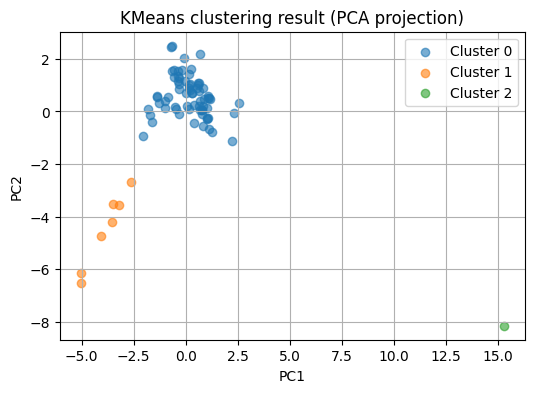

In [ ]:
plt.figure(figsize=(6,4))
for i in range(best_k):
    idx = (labels == i)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=f'Cluster {i}', alpha=0.6)
plt.title("KMeans clustering result (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

📊 Trung bình đặc trưng theo từng cụm:


,price_mean,price_std,price_skew,price_kurt,return_mean,return_abs_mean,return_std,return_skew,return_iqr,vol_mean,vol_std,chg24_std,chg7_std,mcap_mean,mcap_std,volume_to_marketcap,autocorr_lag1,autocorr_lag2,autocorr_vol_lag1
cluster,,,,,,,,,,,,,,,,,,,
0,3.527,0.073,-0.784,3.123,-0.000,0.002,0.005,-2.083,0.002,20.001,0.534,0.050,0.098,23.492,0.125,0.851,0.978,0.956,0.965
1,0.707,0.000,10.424,237.087,-0.000,0.000,0.001,0.818,0.000,20.351,0.676,0.001,0.001,23.033,0.142,0.881,0.106,-0.083,0.805
2,0.795,0.135,-1.485,1.560,0.025,0.052,0.124,3.946,0.032,20.832,0.839,0.215,0.468,22.931,0.110,0.908,0.877,0.675,0.838



 Số coin trong mỗi cụm:
cluster
0    69
1     7
2     1
Name: count, dtype: int64


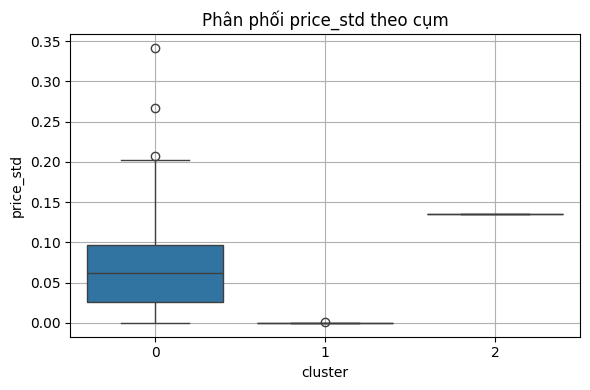

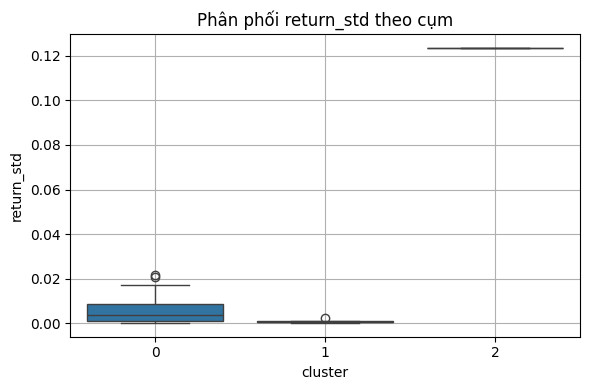

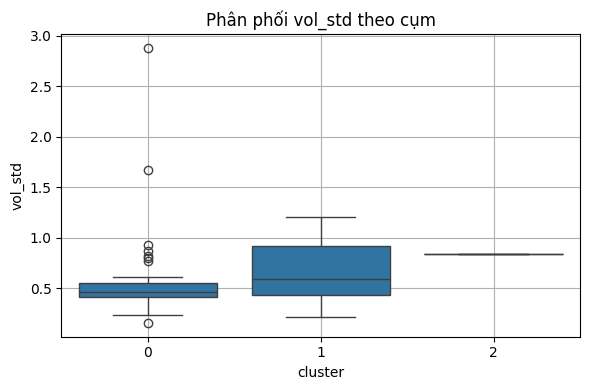

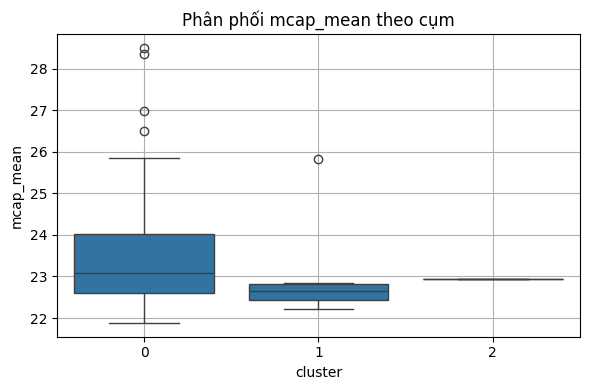

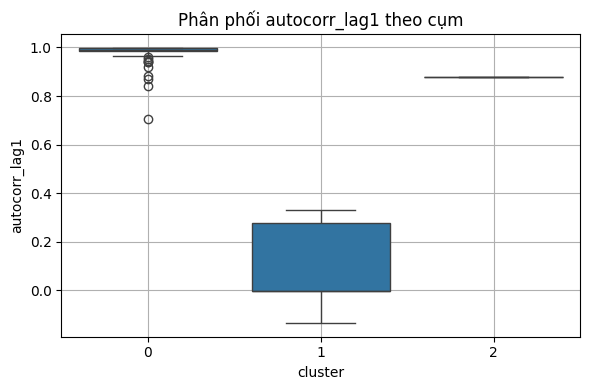

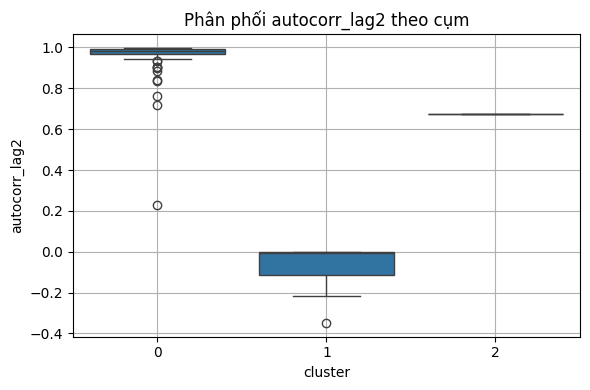

In [ ]:
# Mô tả thống kê các đặc trưng theo từng cụm
cluster_profiles = features.groupby('cluster').mean().round(3)
print("📊 Trung bình đặc trưng theo từng cụm:")
display(cluster_profiles)

# Thống kê số lượng coin trong mỗi cụm
print("\n Số coin trong mỗi cụm:")
print(features['cluster'].value_counts().sort_index())

# Vẽ boxplot cho một số đặc trưng chính
import seaborn as sns

key_features = ['price_std', 'return_std', 'vol_std', 'mcap_mean', 'autocorr_lag1', 'autocorr_lag2']
for feat in key_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=features, x='cluster', y=feat)
    plt.title(f'Phân phối {feat} theo cụm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
